## Car price prediction

In this project, we will use the datasets **`precio_coches_train.csv`** and **`precio_coches_test.csv`**, which contain the following data:

- **Precio**: float.
- **Combustible**: string.
- **Año**: int.
- **Km**: int.
- **CV**: int.
- **Provincia**: string.
- **Marca**: string.

The goal is to train a regression model that can predict the price column.

To train the model, we will only use the data from **`precio_coches_train.csv`**. Experiment with different models and parameters.

After having the model trained, we will conduct tests with **`precio_coches_test.csv`** and calculate regression metrics.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Modelos de Regresión
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

# Métricas para Regresión
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("precio_coches_train.csv")
df_test = pd.read_csv("precio_coches_test.csv")

In [3]:
df_clean = df.copy()
df_clean.head(3)

,Precio,Combustible,Año,Km,CV,Provincia,Marca
0,7999,Diésel,1993,293234,115.0,Zaragoza,NISSAN
1,10990,Gasolina,1993,187000,320.0,Valencia,MERCEDES-BENZ
2,5990,Gasolina,1993,80000,145.0,Madrid,MITSUBISHI


# 1- EDA


#### Let's see the unique value number of each column:

In [4]:
for column in df_clean.columns:
    unique_values = df_clean[column].nunique()
    print(f"{column}: {unique_values} unique values \n")

Precio: 5897 unique values 

Combustible: 6 unique values 

Año: 31 unique values 

Km: 39414 unique values 

CV: 529 unique values 

Provincia: 52 unique values 

Marca: 89 unique values 



In [5]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99304 entries, 0 to 99303
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Precio       99304 non-null  int64  
 1   Combustible  99304 non-null  object 
 2   Año          99304 non-null  int64  
 3   Km           99304 non-null  int64  
 4   CV           99044 non-null  float64
 5   Provincia    99044 non-null  object 
 6   Marca        99304 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


#### Let's take a look at NaN's:

In [6]:
df_nan = (df_clean.isna().sum()*100/len(df_clean)).to_frame()
df_nan.columns = ["percentage_nan %"]
df_nan

,percentage_nan %
Precio,0.000000
Combustible,0.000000
Año,0.000000
Km,0.000000
CV,0.261822
Provincia,0.261822
Marca,0.000000


In [7]:
# Let's analyze this rows
df_clean[df_clean["CV"].isna()].head(3)

,Precio,Combustible,Año,Km,CV,Provincia,Marca
7,58900,Gasolina,1993,42000,NaN,NaN,BMW
8,21900,Gasolina,1993,260000,NaN,NaN,MERCEDES-BENZ
26,19900,Gasolina,1997,67000,NaN,NaN,MINI


In [8]:
df_clean[df_clean["Provincia"].isna()].head(3)

,Precio,Combustible,Año,Km,CV,Provincia,Marca
7,58900,Gasolina,1993,42000,NaN,NaN,BMW
8,21900,Gasolina,1993,260000,NaN,NaN,MERCEDES-BENZ
26,19900,Gasolina,1997,67000,NaN,NaN,MINI


Let's verify that these rows with NaN in 'CV' are the same as those in 'Provincia':

In [9]:
df_clean[df_clean["CV"].isna()].index.tolist() == df_clean[df_clean["Provincia"].isna()].index.tolist()

True

We confirm that the rows are the same for both columns. Since the number of NaN accounts for 0.26% of the total data, we decide to remove the rows because attempting to fill these NaN with any method could introduce noise into our model.

In [10]:
df_clean = df_clean.dropna()

In [11]:
df_clean.isna().sum()

Precio         0
Combustible    0
Año            0
Km             0
CV             0
Provincia      0
Marca          0
dtype: int64

#### Statistics:

In [12]:
df_clean.describe()

,Precio,Año,Km,CV
count,9.904400e+04,99044.000000,9.904400e+04,99044.000000
mean,3.333506e+04,2017.916108,7.293943e+04,166.660525
std,8.841972e+04,4.374258,6.402768e+04,270.486904
min,1.000000e+00,1993.000000,0.000000e+00,1.000000
25%,1.549500e+04,2017.000000,2.401575e+04,110.000000
50%,2.190000e+04,2019.000000,5.992300e+04,130.000000
75%,3.059600e+04,2021.000000,1.052050e+05,177.000000
max,6.800000e+06,2023.000000,3.280000e+06,63824.000000


#### Let's analyze the values of the numerical columns in search of outlier:

In [13]:
def outliers(variable):
    Q1 = variable.quantile(q = 0.25)
    Q3 = variable.quantile(q = 0.75)

    # Rango intercuartil (IQR)
    IQR = Q3 - Q1

    # Calcular los limites inferior y superior
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    
    return lim_inf, lim_sup

In [14]:
df_numeric = df_clean.select_dtypes(include='number')
# El año no nos interesa de momento
df_numeric = df_numeric.drop(["Año"], axis= 1)

In [15]:
df_numeric.columns

Index(['Precio', 'Km', 'CV'], dtype='object')

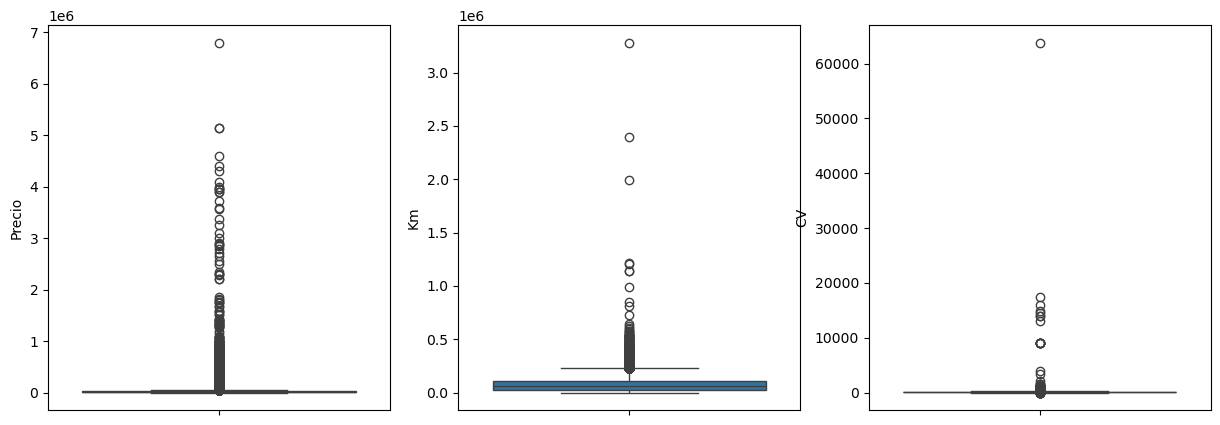

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()

columnas = df_numeric.columns

for k, col in enumerate(columnas):
    sns.boxplot(y = df_numeric[col], ax = ax[k])
    
plt.show()

## Deleting outliers

- CV column:

In [17]:
lim_inf, lim_sup = outliers(df_clean["CV"])
print(f"Limite inferior: {lim_inf}\n Limite superior: {lim_sup}")

Limite inferior: 9.5
 Limite superior: 277.5


After investigating, we found that the majority of cars have a power greater than 20 CV, with low-power cars being electric. The car with the highest power to date has 1700 CV.

In [18]:
percentage_outliers_CV = len(df_clean[~df_clean["CV"].between(20, 1700)])*100/len(df_clean)
round(percentage_outliers_CV, 2)

0.04

In [19]:
df_clean = df_clean[df_clean["CV"].between(20, 1700)]

- Km column: <br>
We've found that the average lifespan of a car is around 250,000 km.

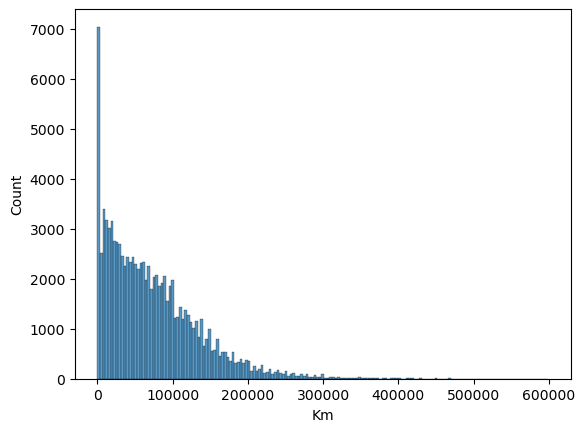

In [20]:
sns.histplot(x = df_clean[df_clean["Km"] < 600000]["Km"]);

Being conservative, we will set an upper limit around 350,000 km.

In [21]:
lim_inf, lim_sup = outliers(df_clean["Km"])
print(f"Limite inferior: {lim_inf}\n Limite superior: {lim_sup}")

Limite inferior: -97702.5
 Limite superior: 226981.5


In [22]:
percentage_outliers_km = len(df_clean[~df_clean["Km"].between(lim_inf, 350000)])*100/len(df_clean)
round(percentage_outliers_km, 2)

0.23

In [23]:
df_clean = df_clean[df_clean["Km"].between(lim_inf, 350000)]

- Precio column: <br>
To analize the price column, we're gonna transform it to log scale

In [24]:
df_clean["precio_log"] = df_clean["Precio"].apply(lambda x : np.log(x))

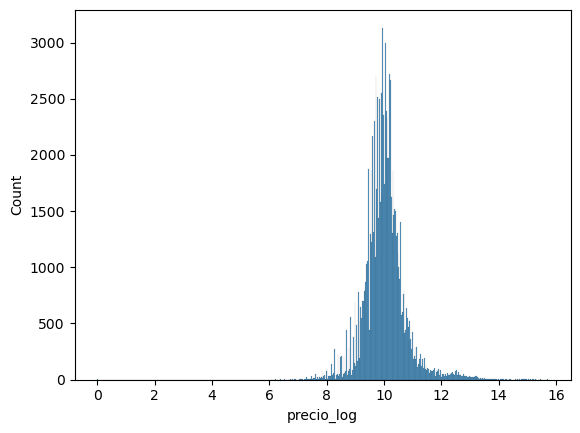

In [25]:
sns.histplot(x = df_clean["precio_log"]);

Let's check the lower and upper limits:

In [26]:
lim_inf, lim_sup = outliers(df_clean["precio_log"])
print(f"Limite inferior: {lim_inf}\n Limite superior: {lim_sup}")

Limite inferior: 8.623461356905413
 Limite superior: 11.357151879577213


In [27]:
print(f"Limite inferior: {np.exp(8)} \n Limite superior: {np.exp(13)}")

Limite inferior: 2980.9579870417283 
 Limite superior: 442413.3920089205


In [28]:
percentage_outliers_km = len(df_clean[(~df_clean["Precio"].between(2980,442413))])*100/len(df_clean)
percentage_outliers_km

1.0033410954743343

In [29]:
df_clean = df_clean[df_clean["Precio"].between(2900,400000)]

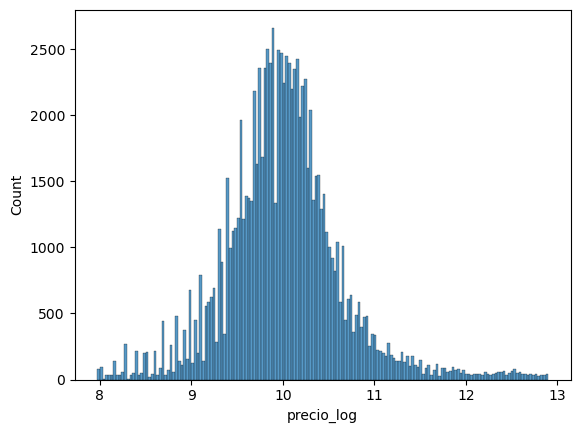

In [30]:
sns.histplot(x = df_clean["precio_log"]);

- Año column:

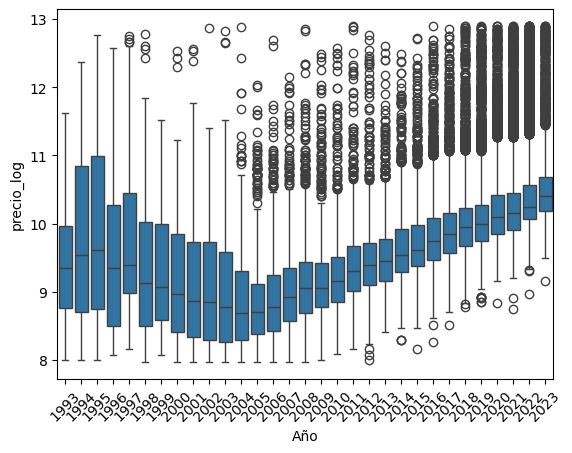

In [31]:
sns.boxplot(x = df_clean["Año"], y = df_clean["precio_log"])
plt.xticks(rotation=45);

Let's analyze this column more thoroughly:

In [32]:
df_clean["Año"].value_counts().to_frame().reset_index().sort_values(by= "Año").head(13)

,Año,count
30,1993,32
29,1994,43
27,1995,54
28,1996,47
26,1997,64
25,1998,68
24,1999,76
23,2000,109
22,2001,124
21,2002,193


In [33]:
lim_inf, lim_sup = outliers(df_clean["Año"])
print(f"Limite inferior: {lim_inf}\n Limite superior: {lim_sup}")

Limite inferior: 2011.0
 Limite superior: 2027.0


Since we observed unusual prices for cars from years < 2004, we decided to remove them as they do not constitute a significant portion of the total.

In [34]:
percentage_outliers_año = len(df_clean[df_clean["Año"] <= 2004])*100/len(df_clean)
percentage_outliers_año

1.5353142740244463

In [35]:
df_clean = df_clean[df_clean["Año"] > 2004]

#### Check for duplicates:

In [36]:
df_clean.duplicated().value_counts()

False    91042
True      5222
Name: count, dtype: int64

In [37]:
df_clean = df_clean.drop_duplicates()

In [38]:
df_clean.shape

(91042, 8)

## Let's analize the relation between the log price and other columns:

In [39]:
df_clean.head(3)

,Precio,Combustible,Año,Km,CV,Provincia,Marca,precio_log
278,11690,Diésel,2005,200000,174.0,Málaga,VOLKSWAGEN,9.366489
279,7900,Diésel,2005,183000,204.0,Madrid,MERCEDES-BENZ,8.974618
280,26990,Gasolina,2005,177000,507.0,Asturias,BMW,10.203222


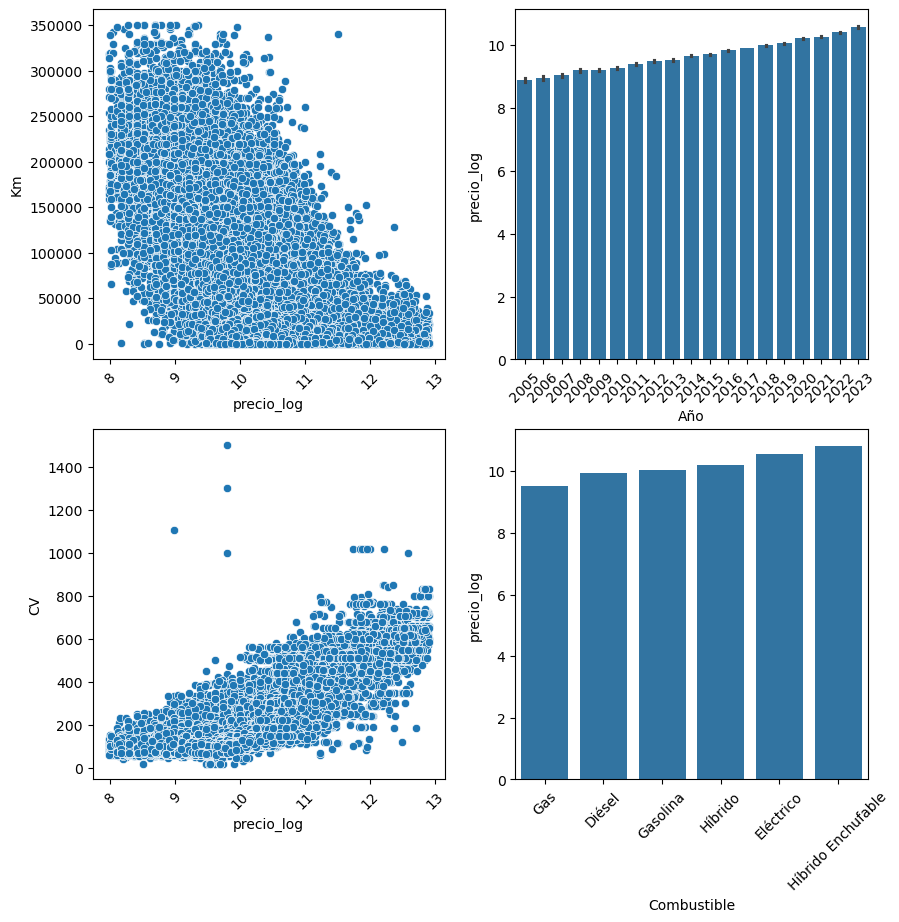

In [40]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

sns.scatterplot(x = df_clean["precio_log"], y = df_clean["Km"], ax = ax[0][0])
sns.barplot(x = df_clean["Año"], y = df_clean["precio_log"], ax = ax[0][1])
sns.scatterplot(x = df_clean["precio_log"], y = df_clean["CV"], ax = ax[1][0])
comb = df_clean.groupby("Combustible")["precio_log"].mean().to_frame().reset_index().sort_values(by="precio_log")
sns.barplot(x = comb["Combustible"], y = comb["precio_log"], ax = ax[1][1])

for axis in ax.flat:
    axis.tick_params(axis='x', labelrotation=45)
plt.show()

#### After removing price outliers, we eliminate the 'price_log' column:

In [41]:
df_clean = df_clean.drop(["precio_log"], axis= 1)

In [42]:
df_clean.head(3)

,Precio,Combustible,Año,Km,CV,Provincia,Marca
278,11690,Diésel,2005,200000,174.0,Málaga,VOLKSWAGEN
279,7900,Diésel,2005,183000,204.0,Madrid,MERCEDES-BENZ
280,26990,Gasolina,2005,177000,507.0,Asturias,BMW


# ¡! Data preprocessing for model training:

In [43]:
class Categorize(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        # Categorizo las marcas de los coches: Gamma alta(> 60k €), Gamma media(entre 30k y 60k €) y Gamma baja(< 30k €)
        # SubDataFrame con el precio medio por marca:
        marca_avg_precio = X.groupby(by= "Marca")["Precio"].mean().to_frame().reset_index()
        # Separo en tres tramos:
        gamma_alta = marca_avg_precio[marca_avg_precio["Precio"] > 60000]["Marca"].values
        gamma_media = marca_avg_precio[marca_avg_precio["Precio"].between(30000,60000)]["Marca"].values
        gamma_baja = marca_avg_precio[marca_avg_precio["Precio"] < 30000]["Marca"].values
        # Creo un diccionario con las marcas en cada gamma:
        gamma_dic = {'alta': gamma_alta, 'media': gamma_media, 'baja': gamma_baja}   
        
        # Vamos a crear tres columnas y poblarlas según corresponda:
        for gamma in gamma_dic.keys():
            X[gamma] = np.zeros(len(X))
            X[gamma] = X["Marca"].apply(lambda x: 1 if x in gamma_dic[gamma] else 0)
        
        return X

        
class Dummies(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y= None):
            return self
            
    def transform(self, X):
        Combustible = pd.get_dummies(data = X["Combustible"], dtype = int)
        X = pd.concat([X, Combustible], axis = 1)
        
        return X
    
    
class Column_dropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        # Elimino las columnas que no utilizaremos en el modelo:
        X = X.drop(["Combustible", "Provincia", "Marca"], axis= 1)
        
        return X

In [44]:
df_train_clean = df_clean.copy()
df_test_clean = df_test.copy()

In [45]:
df_train_clean.head(1)

,Precio,Combustible,Año,Km,CV,Provincia,Marca
278,11690,Diésel,2005,200000,174.0,Málaga,VOLKSWAGEN


In [46]:
df_test_clean.head(1)

,Precio,Combustible,Año,Km,CV,Provincia,Marca
0,139900,Gasolina,2020,37900,600,Madrid,AUDI


In [47]:
pipe_preprocess = Pipeline([("Categorize", Categorize()),
                            ("Dummies", Dummies()),
                            ("Dropper", Column_dropper())])

In [48]:
df_train_preprocesado = pipe_preprocess.fit_transform(df_train_clean)
df_test_preprocesado = pipe_preprocess.fit_transform(df_test_clean)

In [49]:
df_train_preprocesado.head(1)

,Precio,Año,Km,CV,alta,media,baja,Diésel,Eléctrico,Gas,Gasolina,Híbrido,Híbrido Enchufable
278,11690,2005,200000,174.0,0,0,1,1,0,0,0,0,0


In [50]:
df_test_preprocesado.head(1)

,Precio,Año,Km,CV,alta,media,baja,Diésel,Eléctrico,Gas,Gasolina,Híbrido,Híbrido Enchufable
0,139900,2020,37900,600,0,1,0,0,0,0,1,0,0


#### 4- Let's separate the predictor variables and scale the data for both the training and testing sets:

In [51]:
# Separo variables de entrenamiento:
X_train = df_train_preprocesado.drop(["Precio"], axis= 1)
y_train = df_train_preprocesado[["Precio"]]

# Separo variables de testeo:
X_test = df_test_preprocesado.drop(["Precio"], axis= 1)
y_test = df_test_preprocesado[["Precio"]]

# Configuro los scalers:#########################
scaler_x = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train)
#################################################

In [52]:
# Escalo variables de entrenamiento:
X_train = scaler_x.transform(X_train)
y_train = scaler_y.transform(y_train)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

# Escalo variables de testeo:
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test)
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (91042, 12)
y_train: (91042, 1)
X_test: (777, 12)
y_test: (777, 1)


# ¡! Training models:

## 1- LinearRegression Model:

In [53]:
modelo_regr = LinearRegression()
modelo_regr.fit(X_train, y_train)

LinearRegression()

In [54]:
y_pred = modelo_regr.predict(X_test)

# Invierto el scaler:
y_pred_nat = scaler_y.inverse_transform(y_pred)
y_test_nat = scaler_y.inverse_transform(y_test)

# Metricas
mae_LR = mean_absolute_error(y_test_nat, y_pred_nat)
mse_LR = mean_squared_error(y_test_nat, y_pred_nat)
r2_LR = r2_score(y_test_nat, y_pred_nat)

LR_errors = [mae_LR, mse_LR, r2_LR]

print(f"MAE:\t {mae_LR}")
print(f"MSE:\t {mse_LR}")
print(f"R**2:\t {r2_LR}")

MAE:	 6521.8509521484375
MSE:	 114021804.39885315
R**2:	 0.6425402627891138


## 2- KNeighborsRegressor Model:

In [55]:
%%time

list_rsq = list()

for k in range(1, 100):
    
    # Modelo
    modelo_KNR = KNeighborsRegressor(n_neighbors= k)
    modelo_KNR.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo_KNR.predict(X_test)
    
    # Invierto el scaler:
    y_pred_nat = scaler_y.inverse_transform(y_pred)
    y_test_nat = scaler_y.inverse_transform(y_test)

    # Metricas
    rsq = r2_score(y_test_nat, y_pred_nat)
    list_rsq.append([k, rsq])
    
list_rsq = np.array(list_rsq)    
mejor_indice = np.argmax(list_rsq[:, 1])    
print(f"k: {int(list_rsq[mejor_indice, :][0])}, R**2: {list_rsq[mejor_indice, :][1]}")

k: 1, R**2: 0.964851559577523
CPU times: total: 22.3 s
Wall time: 22.1 s


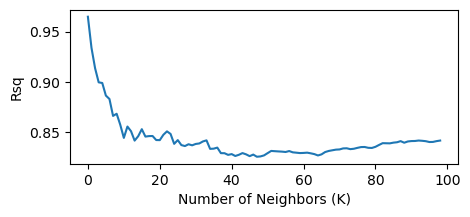

In [56]:
plt.figure(figsize = (5, 2))

plt.plot(list_rsq[:, 1])

plt.ylabel("Rsq")
plt.xlabel("Number of Neighbors (K)")

plt.show()

- KNR con k= 1:

In [57]:
# Modelo
modelo_KNR = KNeighborsRegressor(n_neighbors= 1)
modelo_KNR.fit(X_train, y_train)

# Predicciones
y_pred = modelo_KNR.predict(X_test)

# Invierto el scaler:
y_pred_nat = scaler_y.inverse_transform(y_pred)
y_test_nat = scaler_y.inverse_transform(y_test)

# Métricas
mae_KNR = mean_absolute_error(y_test_nat, y_pred_nat)
mse_KNR = mean_squared_error(y_test_nat, y_pred_nat)
r2_KNR = r2_score(y_test_nat, y_pred_nat)

KNR_errors = [mae_KNR, mse_KNR, r2_KNR]

print(f"MAE:\t {mae_KNR}")
print(f"MSE:\t {mse_KNR}")
print(f"R**2:\t {r2_KNR}")

MAE:	 1069.4131274131273
MSE:	 11211580.442728443
R**2:	 0.964851559577523


## 3- RadiusNeighborsRegressor Model:

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
%%time

list_rsq = list()

for radio in np.arange(0.1, 1, 0.01):
    
    try:
        # Modelo
        model_RNR = RadiusNeighborsRegressor(radius = radio)
        model_RNR.fit(X_train, y_train)

        # Predicciones
        y_pred = model_RNR.predict(X_test)

        # Invierto el scaler:
        y_pred_nat = scaler_y.inverse_transform(y_pred)
        y_test_nat = scaler_y.inverse_transform(y_test)
        
        # Metricas
        rsq = r2_score(y_test_nat, y_pred_nat)
        list_rsq.append([radio, rsq])
        
    except:
        list_rsq.append([radio, 0])
        
list_rsq = np.array(list_rsq)    
mejor_indice = np.argmax(list_rsq[:, 1])    
print(f"radio: {list_rsq[mejor_indice, :][0]}, R**2: {list_rsq[mejor_indice, :][1]}")

k: 0.44999999999999984, R**2: 0.43887190476299454
CPU times: total: 1min 16s
Wall time: 1min 17s


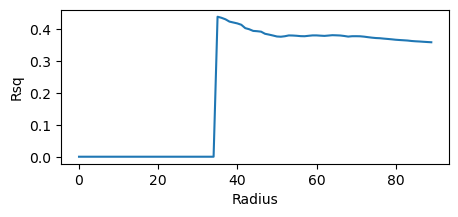

In [60]:
plt.figure(figsize = (5, 2))

plt.plot(list_rsq[:, 1])

plt.ylabel("Rsq")
plt.xlabel("Radius")

plt.show()

- RNR con radio= 0.44999999999999984:

In [64]:
# Modelo
model_RNR = RadiusNeighborsRegressor(radius = 0.44999999999999984)
model_RNR.fit(X_train, y_train)

# Predicciones
y_pred = model_RNR.predict(X_test)

# Invierto el scaler:
y_pred_nat = scaler_y.inverse_transform(y_pred)
y_test_nat = scaler_y.inverse_transform(y_test)

# Métricas
mae_RNR = mean_absolute_error(y_test_nat, y_pred_nat)
mse_RNR = mean_squared_error(y_test_nat, y_pred_nat)
r2_RNR = r2_score(y_test_nat, y_pred_nat)

RNR_errors = [mae_RNR, mse_RNR, r2_RNR]

print(f"MAE:\t {mae_RNR}")
print(f"MSE:\t {mse_RNR}")
print(f"R**2:\t {r2_RNR}")

MAE:	 7757.381366986835
MSE:	 178987536.9378143
R**2:	 0.43887190476299454


### Final Results:

In [65]:
error = [LR_errors, KNR_errors, RNR_errors]
errors = pd.DataFrame(error, columns= ["MAE", "MSE", "R2"])
errors.index = [str(modelo_regr), str(modelo_KNR), str(model_RNR)]

In [66]:
errors

,MAE,MSE,R2
LinearRegression(),6521.850952,1.140218e+08,0.642540
KNeighborsRegressor(n_neighbors=1),1069.413127,1.121158e+07,0.964852
RadiusNeighborsRegressor(radius=0.44999999999999984),7757.381367,1.789875e+08,0.438872
